## Hyperparameter tuning

In [ ]:
!pip install gymnax

In [ ]:
import jax
import jax.numpy as jnp
import optax
import gymnax
import time
import numpy as np
from gymnax.wrappers.purerl import FlattenObservationWrapper
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import random
import pandas as pd
import math

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity, obs_dim, n_envs):
        self.capacity = capacity
        self.n_envs = n_envs
        self.ptr = 0
        self.size = 0   # number of valid samples

        self.obs_buf = jnp.zeros((capacity, obs_dim))
        self.actions_buf = jnp.zeros((capacity,), dtype=jnp.int32)
        self.rewards_buf = jnp.zeros((capacity,))
        self.next_obs_buf = jnp.zeros((capacity, obs_dim))
        self.dones_buf = jnp.zeros((capacity,))

    def add(self, obs, actions, rewards, next_obs, dones):
        """
        Add a batch of transitions from all environments.
        obs: (n_envs, obs_dim)
        actions: (n_envs,)
        rewards: (n_envs,)
        next_obs: (n_envs, obs_dim)
        dones: (n_envs,)
        """
        n = obs.shape[0]
        idxs = (jnp.arange(n) + self.ptr) % self.capacity

        self.obs_buf = self.obs_buf.at[idxs].set(obs)
        self.actions_buf = self.actions_buf.at[idxs].set(actions)
        self.rewards_buf = self.rewards_buf.at[idxs].set(rewards)
        self.next_obs_buf = self.next_obs_buf.at[idxs].set(next_obs)
        self.dones_buf = self.dones_buf.at[idxs].set(dones)

        # advance pointer
        self.ptr = (self.ptr + n) % self.capacity
        # track current size
        self.size = min(self.size + n, self.capacity)

    def sample(self, rng, batch_size):
        max_size = self.size  # only sample from valid entries
        idxs = jax.random.randint(rng, (batch_size,), 0, max_size)
        return (self.obs_buf[idxs],
                self.actions_buf[idxs],
                self.rewards_buf[idxs],
                self.next_obs_buf[idxs],
                self.dones_buf[idxs])

    def __len__(self):
        return self.size


In [ ]:
def rbf_features(x, centers, sigma=0.5):
    # x: (d,) or (batch_size, d), centers: (n_centers, d)

    # Normalize input to appropriate range for CartPole
    x= x / jnp.array([2.4, 3.0, 0.2, 3.0])  # CartPole observation scaling

    diffs = x[None] - centers if x.ndim == 1 else x[:, None] - centers
    sq_dist = jnp.sum(diffs**2, axis=-1)
    return jnp.exp(-sq_dist / (2 * sigma**2))

def init_params(rng, n_features, n_actions):
    W = jax.random.normal(rng, (n_features, n_actions)) * 0.1
    return W

def q_values(W, obs, centers, sigma=0.5):
    phi = rbf_features(obs, centers, sigma)  # (batch_size, n_features) or (n_features,)
    return jnp.dot(phi, W)  # (batch_size, n_actions) or (n_actions,)

def select_action(W, obs, rng, centers, sigma=0.5, epsilon=0.1):
    q = q_values(W, obs, centers, sigma)
    greedy = jnp.argmax(q, axis=-1)
    explore = jax.random.bernoulli(rng, epsilon, shape=greedy.shape)
    random_actions = jax.random.randint(rng, greedy.shape, 0, q.shape[-1])
    return jnp.where(explore, random_actions, greedy)

def td_loss(W, obs, action, reward, next_obs, done, gamma, centers, sigma):
    q = q_values(W, obs, centers, sigma)
    q_selected = jnp.take_along_axis(q, action[:, None], axis=-1).squeeze()

    next_q = jnp.max(q_values(W, next_obs, centers, sigma), axis=-1)
    target = reward + gamma * (1 - done) * next_q

    return jnp.mean(0.5 * (q_selected - target) ** 2)

def epsilon_schedule(step, eps_start=1.0, eps_end=0.05, decay_rate=0.99):
    return jnp.maximum(eps_end, eps_start * (decay_rate ** step))

In [ ]:

def train_one(rng, hyperparams, log_interval=1):
    """
    Returns:
      times_per_ep: array (num_episodes,)
      avg_rewards: array (num_episodes,)
    """
    lr = hyperparams["lr"]
    gamma = hyperparams["gamma"]
    n_centers = hyperparams["n_centers"]
    sigma = hyperparams["sigma"]
    num_envs = hyperparams["num_envs"]
    batch_size = hyperparams["batch_size"]
    steps = hyperparams["steps"]
    update_freq = hyperparams["update_freq"]
    epsilon_decay_rate = hyperparams["epsilon_decay_rate"]
    max_grad_norm = hyperparams["max_grad_norm"]

    # Wrap the environment to ensure consistent observation shapes
    env, env_params = gymnax.make("CartPole-v1")
    env = FlattenObservationWrapper(env)
    env_params = env_params

    obs_dim = env.observation_space(env_params).shape[0]
    n_actions = env.action_space(env_params).n

    # Initialize params
    rng, centers_rng, init_rng, env_rng, step_rng = jax.random.split(rng, 5)
    centers = jax.random.uniform(centers_rng, (n_centers, obs_dim), minval=-1, maxval=1)
    W = init_params(init_rng, n_centers, n_actions)

    # optimizer
    if max_grad_norm:
        opt = optax.chain(
            optax.clip_by_global_norm(max_grad_norm),
            optax.adam(lr)
        )
    else:
      opt = optax.adam(lr)
    opt_state = opt.init(W)

    # Pre-generate keys for resets, actions, steps, and sampling
    env_rngs = jax.random.split(env_rng, num_envs)  # For initial reset
    action_keys = jax.random.split(step_rng, steps * num_envs).reshape(steps, num_envs, 2)
    step_keys = jax.random.split(step_rng, steps * num_envs).reshape(steps, num_envs, 2)
    reset_keys = jax.random.split(step_rng, steps * num_envs).reshape(steps, num_envs, 2)
    sample_keys = jax.random.split(step_rng, steps)

    # Parallelize reset step and select action
    vmap_reset = jax.vmap(env.reset, in_axes=(0, None))
    vmap_step = jax.jit(jax.vmap(env.step, in_axes=(0, 0, 0, None)))
    vmap_select_action = jax.vmap(select_action, in_axes=(None, 0, 0, None, None, None))

    @jax.jit
    def update_batch(W, opt_state, obs, actions, rewards, next_obs, dones):
        def batch_loss(W):
            return td_loss(W, obs, actions, rewards, next_obs, dones, gamma, centers, sigma)
        grads = jax.grad(batch_loss)(W)
        updates, opt_state = opt.update(grads, opt_state, W)
        W = optax.apply_updates(W, updates)
        return W, opt_state

    # Initialize environments
    obs, states = vmap_reset(jnp.array(env_rngs), env_params)

    # Initialize rewards and buffer
    episode_rewards = jnp.zeros(num_envs)
    buffer = ReplayBuffer(capacity=100000, obs_dim=obs_dim, n_envs=num_envs)

    # Move arrays to device
    obs = jax.device_put(obs)
    states = jax.device_put(states)
    action_keys = jax.device_put(action_keys)
    step_keys = jax.device_put(step_keys)
    reset_keys = jax.device_put(reset_keys)
    sample_keys = jax.device_put(sample_keys)

    times_per_ep = []
    rewards_per_ep = []

    t0 = time.perf_counter()
    for step in range(steps):
        # Use pre-split keys
        action_rngs = action_keys[step]
        step_rngs = step_keys[step]
        reset_rngs = reset_keys[step]
        sample_rng = sample_keys[step]

        epsilon = epsilon_schedule(steps, eps_start=1.0, eps_end=0.01, decay_rate=epsilon_decay_rate)

        actions = vmap_select_action(W, obs, jnp.array(action_rngs), centers, sigma, epsilon)
        next_obs, next_states, rewards, dones, _ = vmap_step(
            jnp.array(step_rngs), states, actions, env_params
        )

        buffer.add(obs, actions, rewards, next_obs, dones.astype(jnp.float32))
        episode_rewards += rewards

        completed_mask = dones.astype(bool)
        completed_rewards = episode_rewards[completed_mask]

        if completed_rewards.size > 0:
            for r in completed_rewards.tolist():
                times_per_ep.append(time.perf_counter() - t0)
                rewards_per_ep.append(r)

        episode_rewards = episode_rewards * (1 - dones.astype(jnp.float32))

        reset_obs, reset_states = vmap_reset(jnp.array(reset_rngs), env_params)
        obs = jnp.where(dones[:, None], reset_obs, next_obs)
        states = jtu.tree_map(lambda r, n: jnp.where(dones, r, n), reset_states, next_states)

        if buffer.size > 2000:
            for i in range(update_freq):
                batch_obs, batch_actions, batch_rewards, batch_next_obs, batch_dones = \
                    buffer.sample(sample_rng, batch_size)
                W, opt_state = update_batch(W, opt_state,
                                            batch_obs, batch_actions, batch_rewards,
                                            batch_next_obs, batch_dones)

    return (jnp.array(times_per_ep),
            jnp.array(rewards_per_ep))

def plot_results(results):
    n_rows = 2
    n_cols = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
    axes = axes.flatten()  # flatten for easy indexing

    for i, res in enumerate(results):
        if i >= n_rows * n_cols:
            break  # only plot up to 8 runs
        cfg = res["cfg"]
        label = f"lr={cfg['lr']}, batch_size = {cfg['batch_size']}"

        axes[i].plot(res["times"], res["rewards"])
        axes[i].set_title(label, fontsize=10)
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("Reward")
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i+1, n_rows * n_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def main(hyperparams_list):
    rng = jax.random.PRNGKey(0)

    results = []
    for i, cfg in enumerate(hyperparams_list):
        t0 = time.perf_counter()
        rng, subkey = jax.random.split(rng)
        times, rewards = train_one(subkey, cfg)
        results.append({"cfg": cfg, "times": times, "rewards": rewards})
        elapsed = time.perf_counter() - t0
        print(f"Finished run {i+1}/{len(hyperparams_list)} | Elapsed time: {elapsed}")

    plot_results(results)


Finished run 1/1 | Elapsed time: 347.33517618999997


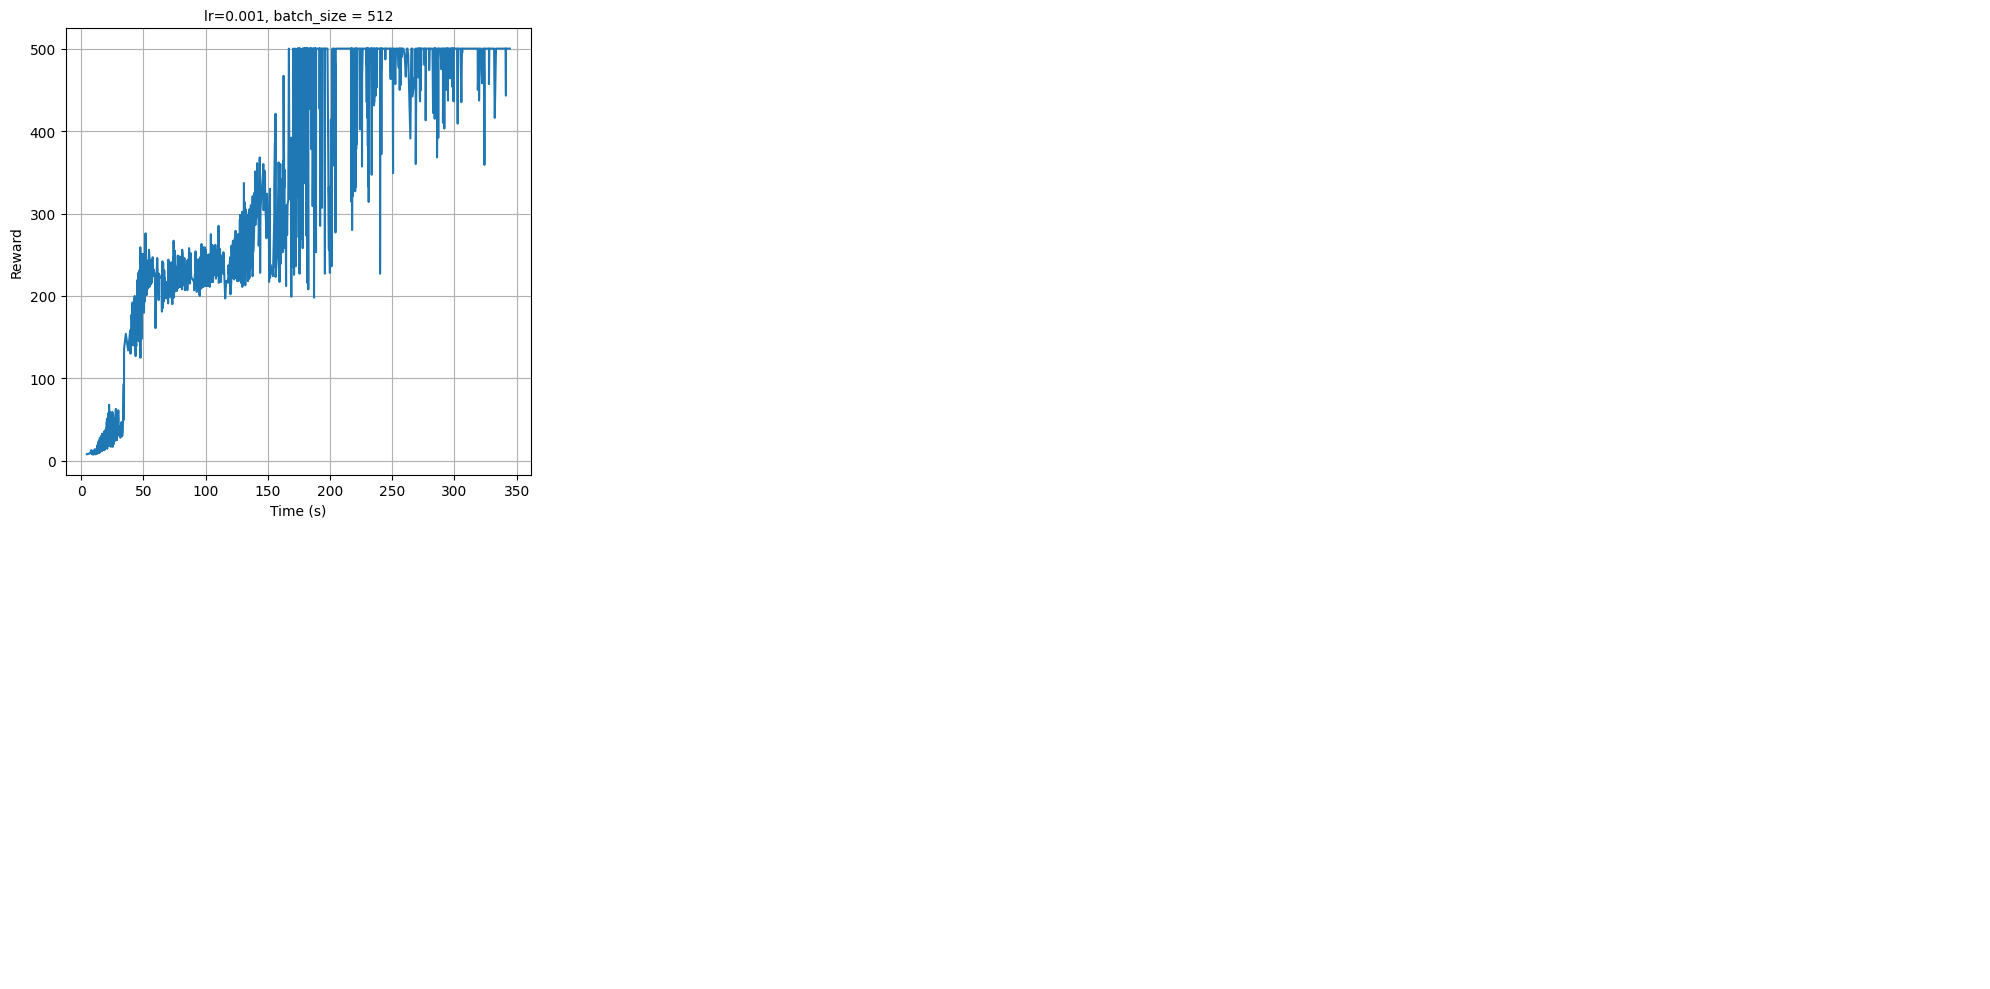

In [ ]:
hyperparams_list = [
    {"lr": 1e-3, "batch_size": 512, "sigma": 0.5, "n_centers": 500, "num_envs": 256, "gamma": 0.99, "steps":3000, "update_freq":8, "epsilon_decay_rate": 0.999, "max_grad_norm": 0},
]

main(hyperparams_list)

In [ ]:
def smooth(x, window=50):
    """Simple moving average for smoothing."""
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode="valid")

def evaluate_configs(hyperparams_list, num_seeds=3, steps=10, smooth_window=50):
    results = []
    summary = []

    for i, cfg in enumerate(hyperparams_list):
        all_rewards = []
        all_times = []

        for seed in range(num_seeds):
            rng = jax.random.PRNGKey(seed)
            times, rewards = train_one(rng, {**cfg, "steps": steps})
            all_rewards.append(np.array(rewards))
            all_times.append(np.array(times))

        max_len = max(len(r) for r in all_rewards)
        padded_rewards = np.array([
            np.pad(r, (0, max_len - len(r)), constant_values=np.nan)
            for r in all_rewards
        ])
        padded_times = np.array([
            np.pad(t, (0, max_len - len(t)), constant_values=np.nan)
            for t in all_times
        ])

        mean_rewards = np.nanmean(padded_rewards, axis=0)
        std_rewards = np.nanstd(padded_rewards, axis=0)
        mean_times = np.nanmean(padded_times, axis=0)

        # Smooth the curve
        smoothed_mean = smooth(mean_rewards, window=smooth_window)
        smoothed_times = mean_times[:len(smoothed_mean)]

        # Metrics
        final_100 = np.nanmean(padded_rewards[:, -100:])  # last 100 episodes
        success_rate = np.mean(padded_rewards[:, -100:] >= 500)
        best_perf = np.nanmax(padded_rewards)
        auc = np.nansum(mean_rewards)

        results.append({
            "cfg": cfg,
            "mean_rewards": smoothed_mean,
            "std_rewards": std_rewards[:len(smoothed_mean)],
            "mean_times": smoothed_times,
            "metrics": {
                "final_100": final_100,
                "success_rate": success_rate,
                "best": best_perf,
                "auc": auc
            }
        })

        summary.append({
            "lr": cfg["lr"],
            "batch_size": cfg["batch_size"],
            "eps_decay": cfg["epsilon_decay_rate"],
            "Final100": final_100,
            "SuccessRate(%)": 100 * success_rate,
            "BestReward": best_perf,
            "AUC": auc
        })

    # Turn into table
    summary_df = pd.DataFrame(summary)
    return results, summary_df

def plot_tuning_results(results, max_cols=4):
    n_cfg = len(results)
    n_cols = min(max_cols, n_cfg)
    n_rows = math.ceil(n_cfg / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten() if n_cfg > 1 else [axes]

    for i, res in enumerate(results):
        cfg = res["cfg"]
        label = (f"lr={cfg['lr']}, "
                 f"batch={cfg['batch_size']}, "
                 f"eps_decay={cfg['epsilon_decay_rate']}")

        mean = res["mean_rewards"]
        std = res["std_rewards"]
        times = res["mean_times"]

        axes[i].plot(times, mean, label="mean reward")
        axes[i].fill_between(times, mean-std, mean+std, alpha=0.3)
        axes[i].set_title(label, fontsize=9)
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("Reward")
        axes[i].grid(True)

    # Hide empty subplots
    for j in range(len(results), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


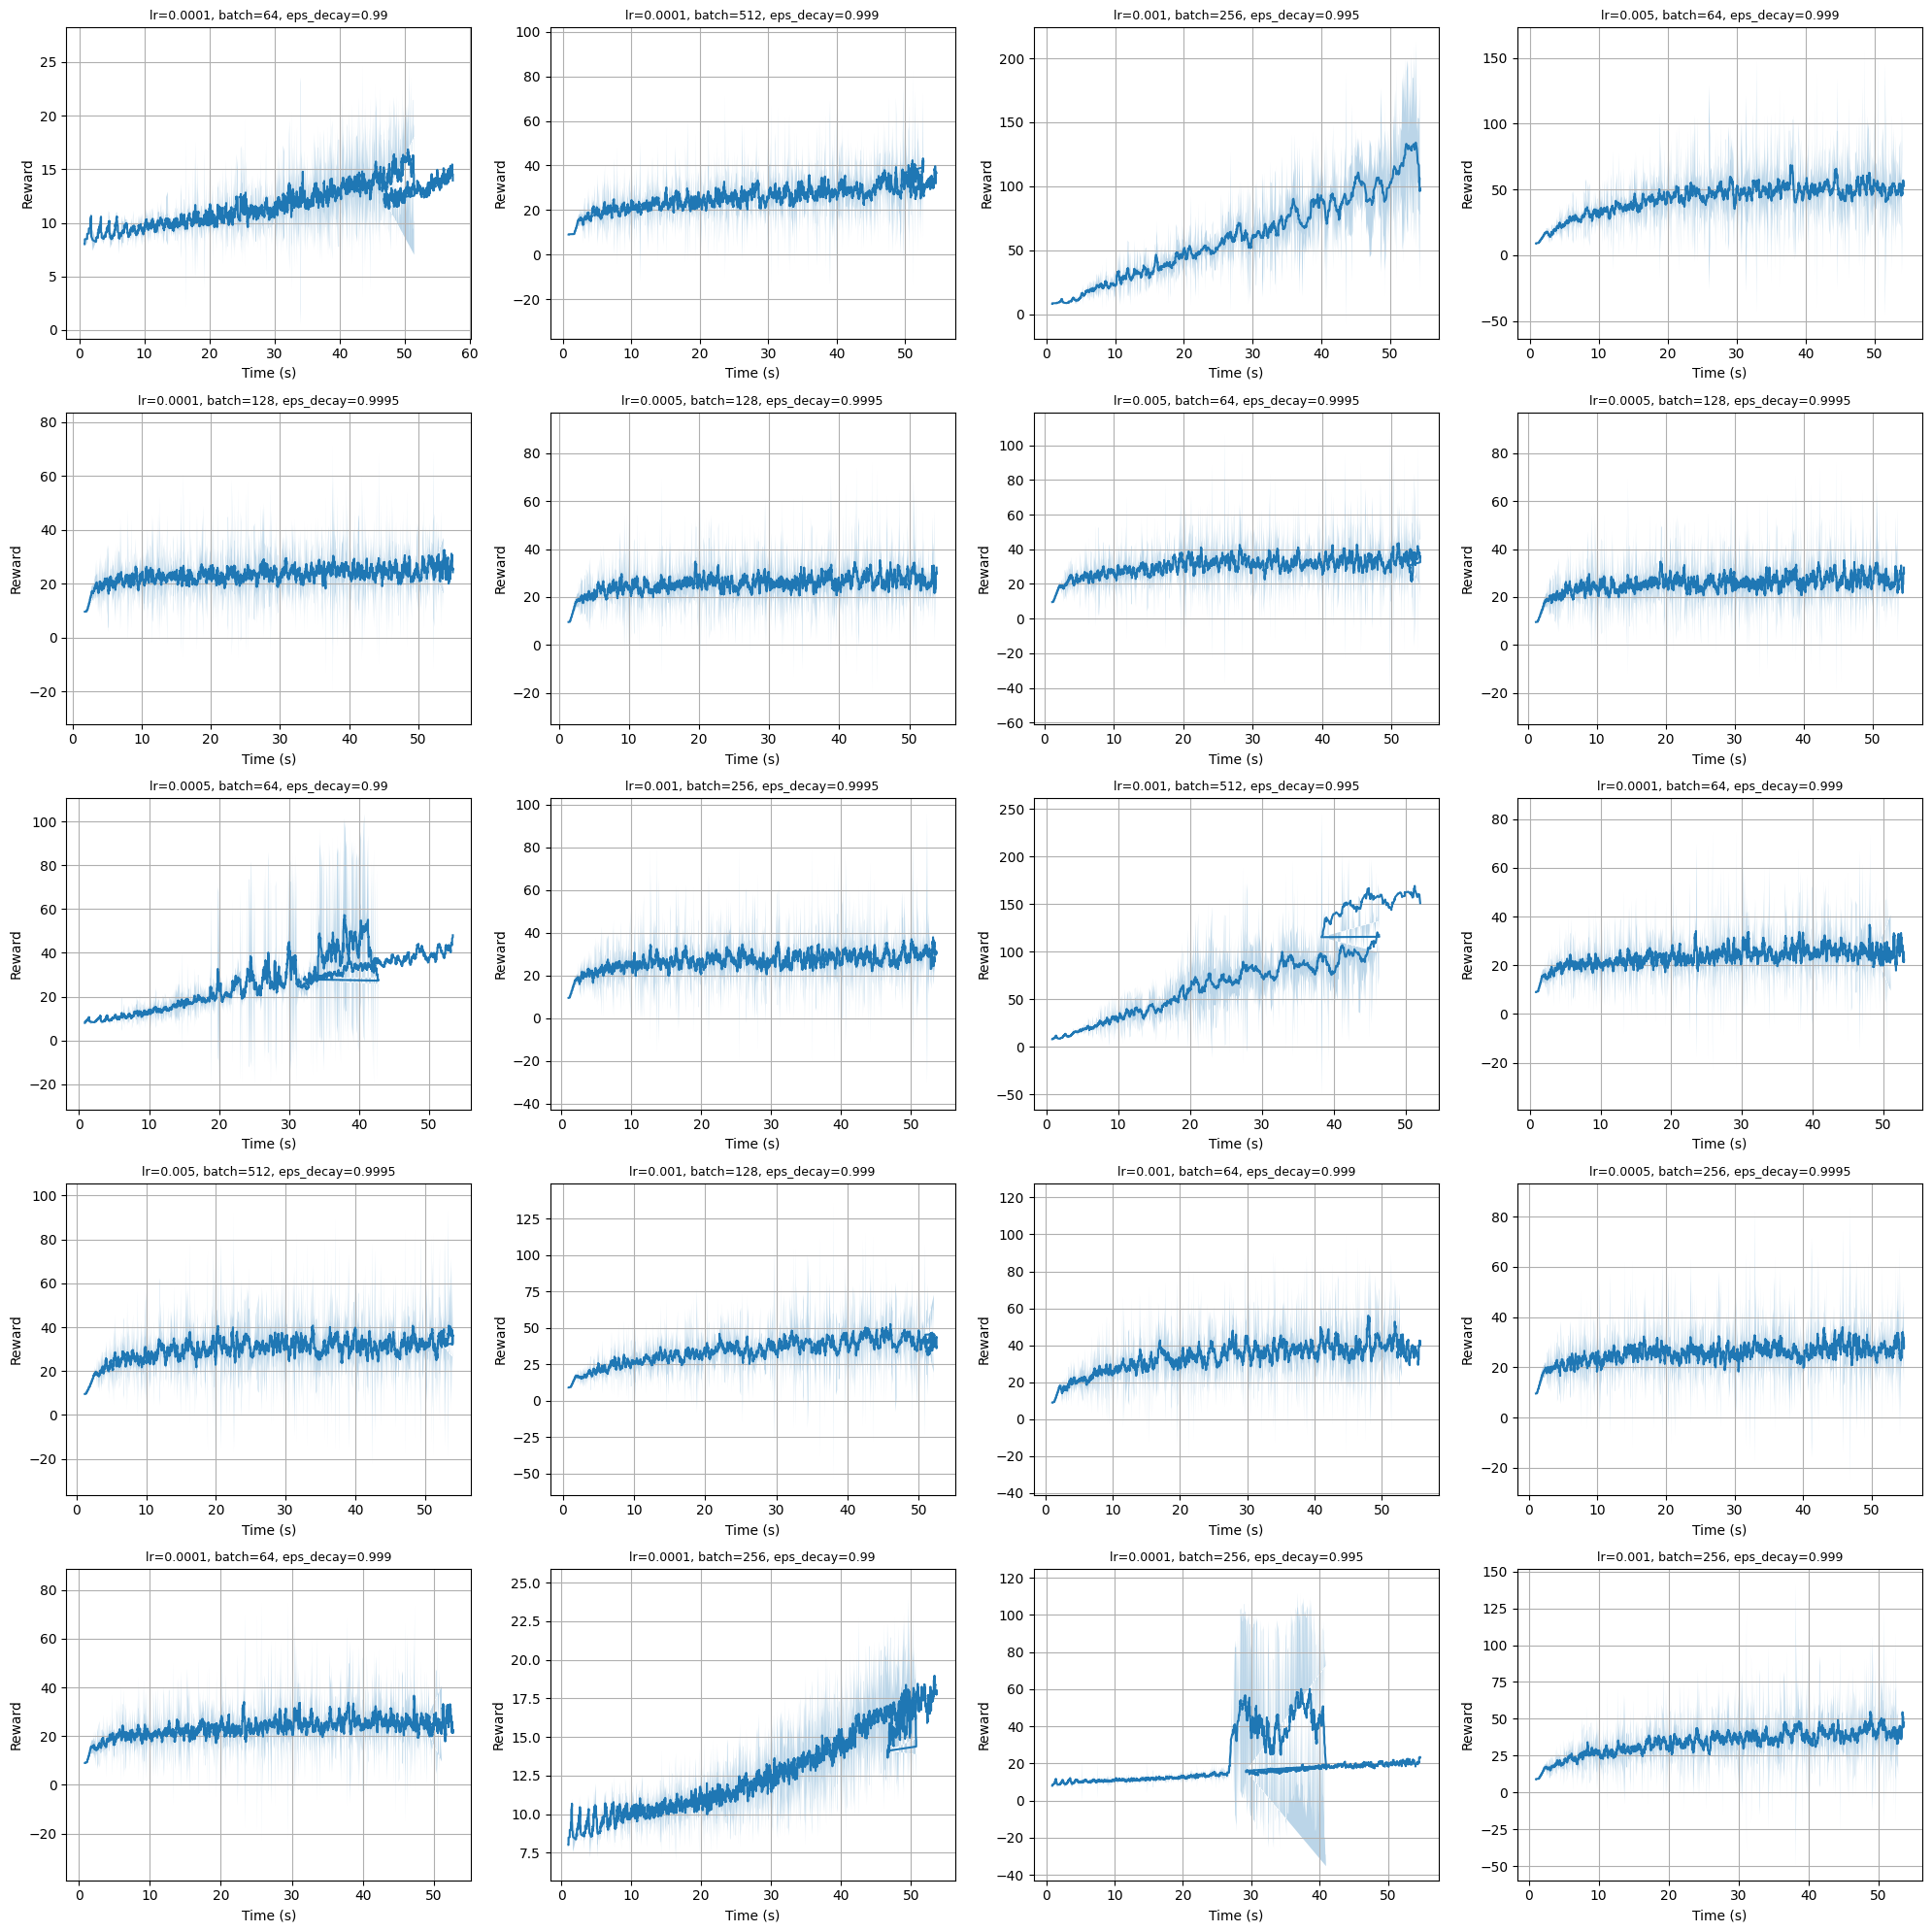


=== Summary Table ===
    lr  batch_size  eps_decay   Final100  SuccessRate(%)  BestReward      AUC
0.0001          64     0.9900  14.720000             0.0        34.0 137596.0
0.0001         512     0.9990  33.830002             0.0       152.0 126374.5
0.0010         256     0.9950 115.172043             0.0       288.0 107237.5
0.0050          64     0.9990  50.907974             0.0       258.0 118766.5
0.0001         128     0.9995  25.510000             0.0       124.0 128059.5
0.0005         128     0.9995  28.511110             0.0       143.0 124064.5
0.0050          64     0.9995  33.625000             0.0       182.0 123413.0
0.0005         128     0.9995  28.511110             0.0       143.0 124064.5
0.0005          64     0.9900  42.900002             0.0       143.0 145205.5
0.0010         256     0.9995  29.859505             0.0       143.0 124074.0
0.0010         512     0.9950 156.779999             0.0       354.0 123970.0
0.0001          64     0.9990  27.120001 

In [ ]:
n_samples = 20  # number of random configurations
hyperparams_list = []

for _ in range(n_samples):
    lr = random.choice([1e-4, 5e-4, 1e-3, 5e-3])
    batch_size = random.choice([64, 128, 256, 512])
    eps_decay = random.choice([0.9995, 0.999, 0.995, 0.99])

    hyperparams_list.append({
        "lr": lr,
        "batch_size": batch_size,
        "epsilon_decay_rate": eps_decay,
        "gamma": 0.99,
        "n_centers": 500,
        "sigma": 0.5,
        "num_envs": 256,
        "update_freq": 8,
        "max_grad_norm": 0  # linear model, no clipping
    })


if __name__ == "__main__":
    results, summary_df = evaluate_configs(hyperparams_list, num_seeds=2, steps=500, smooth_window=20)
    plot_tuning_results(results)

    print("\n=== Summary Table ===")
    print(summary_df.to_string(index=False))


Based on the graph, we can see that a few hyperparams configs stand out. We will pick 5 sets of hyperparams based on our visualization together with the numeric summary (best performing for the final 100 episodes) and train for longer and compare their performances.

In [ ]:
summary_df.sort_values(ascending = False, by = "Final100")[:5]

,lr,batch_size,eps_decay,Final100,SuccessRate(%),BestReward,AUC
10,0.0010,512,0.995,156.779999,0.0,354.0,123970.0
2,0.0010,256,0.995,115.172043,0.0,288.0,107237.5
3,0.0050,64,0.999,50.907974,0.0,258.0,118766.5
8,0.0005,64,0.990,42.900002,0.0,143.0,145205.5
19,0.0010,256,0.999,41.759998,0.0,222.0,123272.5


In [ ]:
final_hyperparams_list = [
    {"lr": 0.001, "batch_size": 256, "epsilon_decay_rate": 0.995,"gamma": 0.99,"n_centers": 500,  "sigma": 0.5, "num_envs": 256, "update_freq": 8, "max_grad_norm": 0},
    {"lr": 0.001, "batch_size": 512, "epsilon_decay_rate": 0.995,"gamma": 0.99,"n_centers": 500,  "sigma": 0.5, "num_envs": 256, "update_freq": 8, "max_grad_norm": 0},
    {"lr": 0.001, "batch_size": 256, "epsilon_decay_rate": 0.999,"gamma": 0.99,"n_centers": 500,  "sigma": 0.5, "num_envs": 256, "update_freq": 8, "max_grad_norm": 0},
    {"lr": 0.005, "batch_size": 64, "epsilon_decay_rate": 0.99,"gamma": 0.99,"n_centers": 500,  "sigma": 0.5, "num_envs": 256, "update_freq": 8, "max_grad_norm": 0},
    {"lr": 0.0095, "batch_size": 64, "epsilon_decay_rate": 0.990,"gamma": 0.99,"n_centers": 500,  "sigma": 0.5, "num_envs": 256, "update_freq": 8, "max_grad_norm": 0},
]

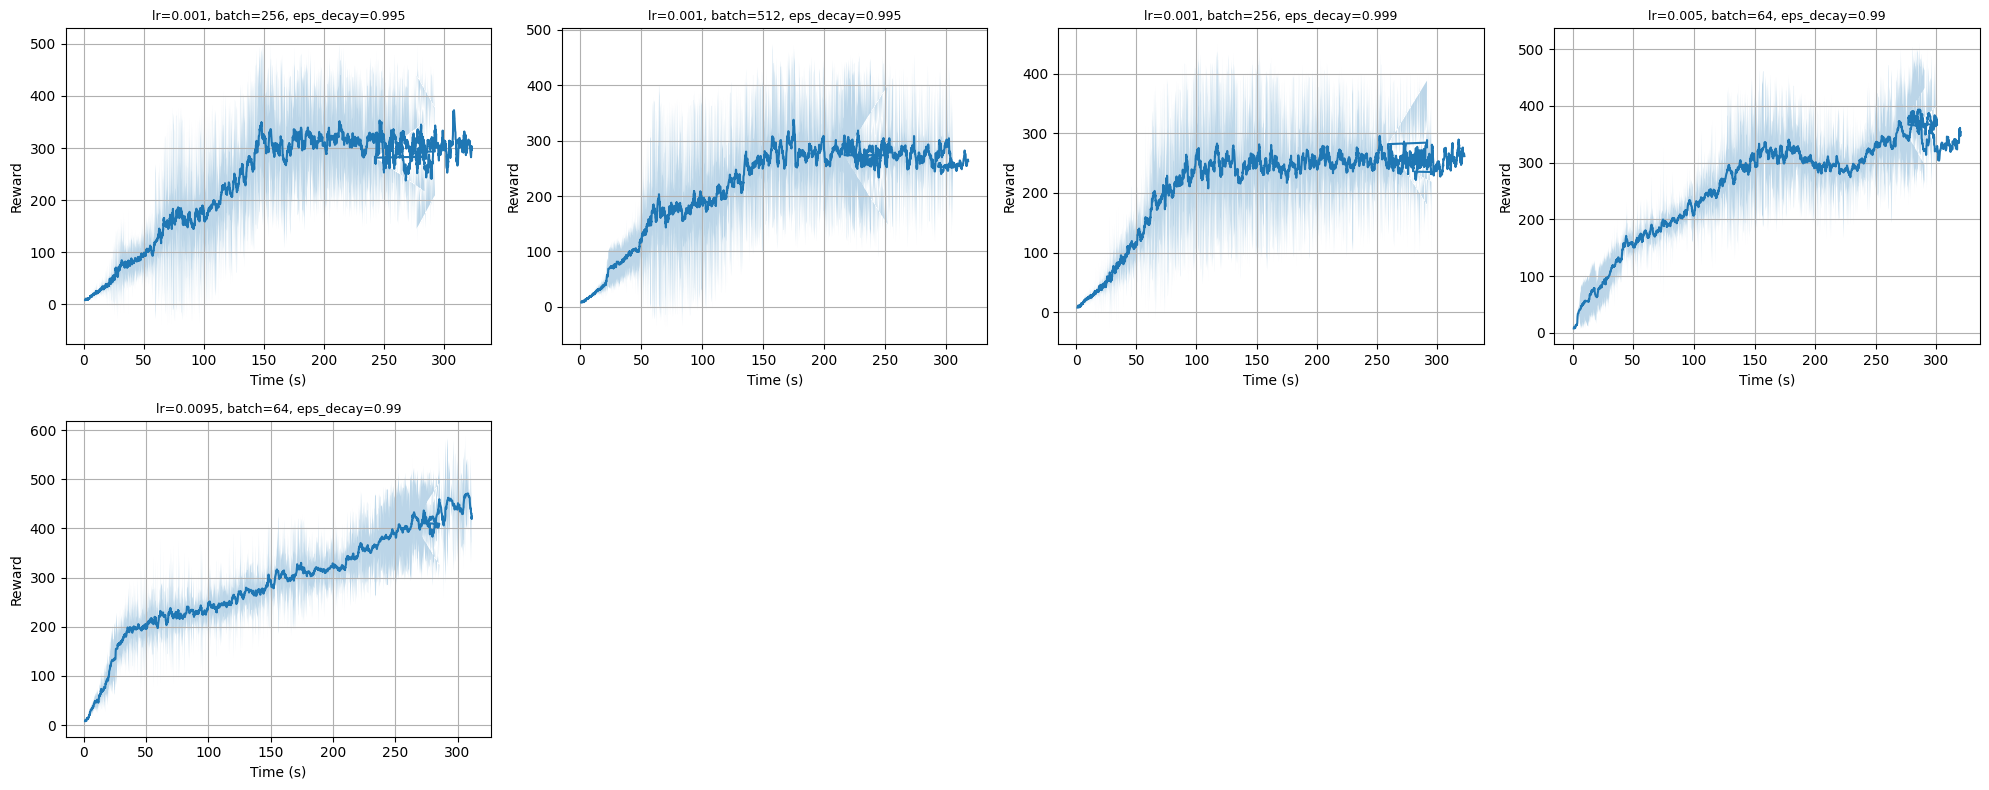


=== Summary Table ===
    lr  batch_size  eps_decay   Final100  SuccessRate(%)  BestReward         AUC
0.0010         256      0.995 304.420013        4.000000       500.0 861981.0625
0.0010         512      0.995 260.500000        0.000000       500.0 842821.3750
0.0010         256      0.999 264.160004        1.000000       500.0 845835.1875
0.0050          64      0.990 338.309998        0.666667       500.0 793555.1875
0.0095          64      0.990 445.609375       36.000000       500.0 739207.6875


In [ ]:
if __name__ == "__main__":
    results, summary_df = evaluate_configs(final_hyperparams_list, num_seeds=3, steps=3000, smooth_window=20)
    plot_tuning_results(results)

    print("\n=== Summary Table ===")
    print(summary_df.to_string(index=False))

It seems like the last parameter is doing the best, so we will finally choose this parameter set for our final model

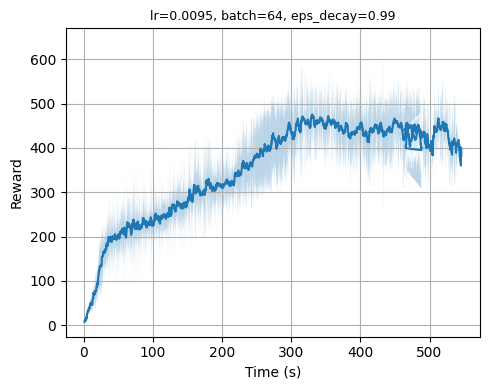


=== Summary Table ===
    lr  batch_size  eps_decay   Final100  SuccessRate(%)  BestReward        AUC
0.0095          64       0.99 400.751709            13.0       500.0 1288818.25


In [20]:
final_hyperparams_list = [
    {"lr": 0.0095, "batch_size": 64, "epsilon_decay_rate": 0.990,"gamma": 0.99,"n_centers": 500,  "sigma": 0.5, "num_envs": 256, "update_freq": 8, "max_grad_norm": 0}
]

if __name__ == "__main__":
    results, summary_df = evaluate_configs(final_hyperparams_list, num_seeds=3, steps=5000, smooth_window=20)
    plot_tuning_results(results)

    print("\n=== Summary Table ===")
    print(summary_df.to_string(index=False))